In [1]:
import sys,os,re
import numpy             as np
import matplotlib.pyplot as plt
import pandas            as pd
import seaborn           as sb

from theory_code.distance_theory import TheoryCalcs
from mock_data.mock_data_code    import MockCalcs

from cobaya.run import run

from itertools import product
from copy      import deepcopy
from time      import time
from bios      import read

from scipy.interpolate import interp1d
from scipy.integrate   import trapz

import warnings
warnings.filterwarnings('ignore')

import matplotlib
from matplotlib import rc
from matplotlib.pyplot import cm
from matplotlib.colors import LogNorm

rc('text', usetex=True)
rc('font', family='serif')
matplotlib.rcParams.update({'font.size': 18})


sidelegend = {'bbox_to_anchor': (1.04,0.5), 
              'loc': "center left",
              'frameon': False}

# Settings

## Theory

In [2]:
fiducial = {'H0': 68.53,
            'omegam': 0.2948,
            'ombh2': 0.02218,
            'omk': 0.,
            'epsilon0_EM': 0.,
            'epsilon0_GW': 0.,
            'mnu': 0.06,
            'nnu': 3.,
            'MB': -19.2435}

settings = {'zmin': 0.001,
            'zmax': 5.,
            'Nz': 1000,
            'zdrag': 1060,
            'DDR_model': 'constant'}


## Observables

In [12]:
obs_settings = {'BAO' : {'distribution': 'binned',
                         'error_type' : 0.05,
                         'correlation': False,
                         'BAO_file_path' : './mock_data/BAOmock_standard',
                         'zmin': 0.65,
                         'zmax': 1.85,
                         'N_bin': 14,
                         #'run_settings': {'file': 'settings/BAO_LCDM.yaml',
                         #                 'varpar': 'H0',
                         #                 'varvec': np.linspace(62,74,100)}
                        },
                'SN' : {'distribution': 'Euclid',
                        'error_type' : 'LSST-like',
                        'correlation': False,
                        'SN_file_path' : './mock_data/SNmock_standard',
                        'zmin': 0.1,
                        'zmax': 1.0,
                        'N_SN': 8800,
                        #'run_settings': {'file': 'settings/SN_LCDM.yaml',
                        #                 'varpar': 'omegam',
                        #                 'varvec': np.linspace(0.1,0.5,10)}
                       },
               'GW' : {'distribution': 'BNS',
                       'error_type' : 0.1,
                       'GW_file_path' : './mock_data/GWmock_standard',
                       'correlation': False,
                       'zmin': 0.001,
                       'zmax': 5.0,
                       'N_gw': 1000,
                       #'run_settings': {'file': 'settings/GW_LCDM.yaml',
                       #                 'varpar': 'H0',
                       #                 'varvec': np.linspace(62,74,100)}
                      }
               }

# Creating mock data

## Getting fiducial theory

In [13]:
fiducial_theory = TheoryCalcs(settings,fiducial)
zplot = np.linspace(0.01,3,100)

## Initializing mock class

In [14]:
mock = MockCalcs(settings, obs_settings, fiducial, fiducial_theory)

CREATING MOCKS FOR ['BAO', 'SN', 'GW']
CREATED BAO DATASET
CREATED SN DATASET
CREATED GW DATASET


## BAO data

**Minor problem here: the format with which BAO_data is obtained is different from the one used in the likelihood. we should make those match**

**Also, DV should probably be on different redshifts than DH and DM**

In [15]:
if 'BAO' in obs_settings:
    BAO_data = mock.data_BAO

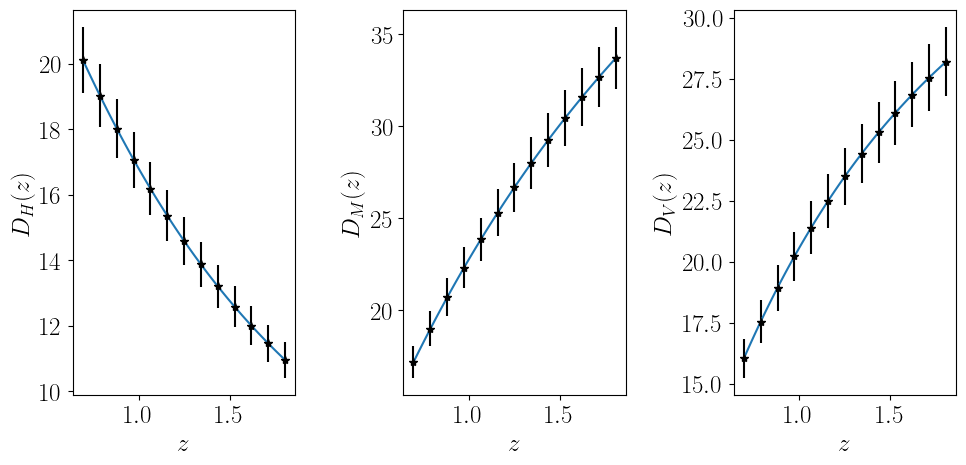

In [16]:
if 'BAO' in obs_settings:
    
    zplot = np.linspace(min(BAO_data['z']),max(BAO_data['z']),100)
    
    fig, axes = plt.subplots(ncols=3, nrows=1, sharex=True,subplot_kw=dict(frameon=True),figsize=(10,5))
    axes[0].errorbar(BAO_data['z'],BAO_data['DH'],yerr=BAO_data['err_DH'],ls='',marker='*',color='black')
    axes[0].plot(zplot,fiducial_theory.DH(zplot))
    axes[0].set_xlabel(r'$z$')
    axes[0].set_ylabel(r'$D_H(z)$')
    
    axes[1].errorbar(BAO_data['z'],BAO_data['DM'],yerr=BAO_data['err_DM'],ls='',marker='*',color='black')
    axes[1].plot(zplot,fiducial_theory.DM(zplot))
    axes[1].set_xlabel(r'$z$')
    axes[1].set_ylabel(r'$D_M(z)$')
    
    axes[2].errorbar(BAO_data['z'],BAO_data['DV'],yerr=BAO_data['err_DV'],ls='',marker='*',color='black')
    axes[2].plot(zplot,fiducial_theory.DV(zplot))
    axes[2].set_xlabel(r'$z$')
    axes[2].set_ylabel(r'$D_V(z)$')
    
    plt.tight_layout();

## SN data

In [17]:
if 'SN' in obs_settings:
    SN_data = deepcopy(mock.data_SN)
    weird = []
    for z,val,err in zip(SN_data['z'],SN_data['mB'],SN_data['err_mB']):
        if val<fiducial_theory.mB(z)+2*err and val>fiducial_theory.mB(z)-2*err:
            weird.append('No')
        else:
            weird.append('Yes')
    SN_data['Weird'] = weird
    
    SNdf = pd.DataFrame.from_dict(SN_data)

Weird points are 0.0%


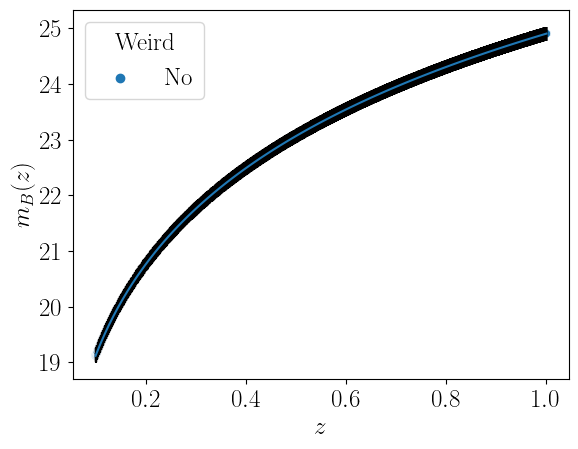

In [18]:
if 'SN' in obs_settings:
    print('Weird points are {}%'.format(100*(len(SNdf[SNdf['Weird']=='Yes']))/len(SNdf)))
    zplot = np.linspace(min(SN_data['z']),max(SN_data['z']),100)
    
    plt.figure()
    plt.errorbar(SN_data['z'],SN_data['mB'],yerr=SN_data['err_mB'],ls='',marker='',color='black')
    sb.scatterplot(SNdf,x='z',y='mB',hue='Weird')
    plt.plot(zplot,fiducial_theory.mB(zplot))
    plt.xlabel(r'$z$')
    plt.ylabel(r'$m_B(z)$');

## Standard Sirens data

In [19]:
if 'GW' in obs_settings:    
    GW_data = deepcopy(mock.data_GW)
    weird = []
    for z,val,err in zip(GW_data['z'],GW_data['dL'],GW_data['err_dL']):
        if val<fiducial_theory.DL_GW(z)+2*err and val>fiducial_theory.DL_GW(z)-2*err:
            weird.append('No')
        else:
            weird.append('Yes')
    GW_data['Weird'] = weird
    GWdf = pd.DataFrame.from_dict(GW_data)

Weird points are 0.0%


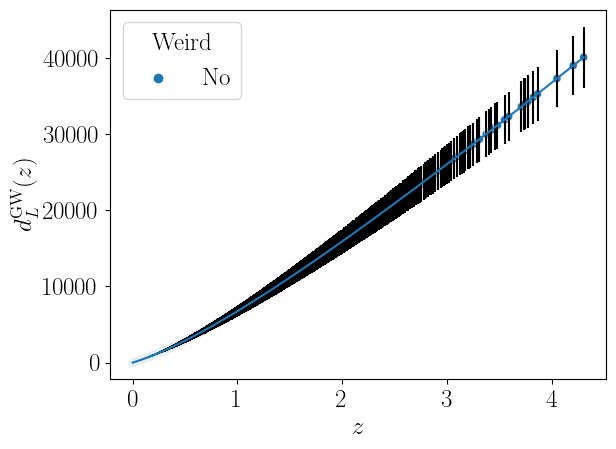

In [20]:
if 'GW' in obs_settings: 
    print('Weird points are {}%'.format(100*len(GWdf[GWdf['Weird']=='Yes'])/len(GWdf)))
    zplot = np.linspace(min(GW_data['z']),max(GW_data['z']),100)
    
    plt.figure()
    plt.errorbar(GWdf['z'],GWdf['dL'],yerr=GWdf['err_dL'],ls='',marker='',color='black')
    sb.scatterplot(GWdf,x='z',y='dL',hue='Weird')
    plt.plot(zplot,fiducial_theory.DL_GW(zplot))
    plt.xlabel(r'$z$')
    plt.ylabel(r'$d_L^{\rm GW}(z)$');

# Grid testing in created data

In [ ]:
from likelihood.BAO_likelihood         import BAOLike
from likelihood.SN_likelihood          import SNLike
from likelihood.GW_likelihood          import GWLike
from theory_code.cobaya_theory_wrapper import CalcDist

dflist = []

for obs,obs_dict in obs_settings.items():
    if 'run_settings' in obs_dict:
        rundict = obs_dict['run_settings']
        info = read(rundict['file'])
        
        info['likelihood'] = {}
        if obs == 'BAO':
            info['likelihood']['BAOLike'] = {'external': BAOLike,
                                             'BAO_data_path': info['BAO_data']}
        
        if obs == 'SN':
            info['likelihood']['SNLike'] =  {'external': SNLike,
                                             'SN_data_path': info['SN_data']}
        
        if obs == 'GW':
            info['likelihood']['GWLike'] =  {'external': GWLike,
                                             'GW_data_path': info['GW_data']}
        
        info['theory'] = {'CalcDist': {'external': CalcDist}}

        del info['output']
        for par,par_dict in info['params'].items():
            if par != rundict['varpar']:
                if type(par_dict) == dict and 'prior' in par_dict:
                    info['params'][par] = fiducial[par]
                    
        for val in rundict['varvec']:
            temp = deepcopy(info)
            temp['sampler'] = {'evaluate': {'override': {rundict['varpar']: val}}}
            updated_info,sampler = run(temp)
            
            dflist.append(pd.DataFrame.from_dict({rundict['varpar']: [val],
                                                  'loglike': [sampler.logposterior.loglike],
                                                  'Observable': [obs]}))
            
test_results = pd.concat(dflist,ignore_index=True)

In [ ]:
from scipy.integrate import trapezoid
playground = test_results.copy()
playground['P_unnorm'] = np.exp(playground['loglike'])
playground['chi2_norm'] = -2*playground['loglike']-min(-2*playground['loglike'])
playground['P'] = np.exp(playground['loglike'])
for obs in playground['Observable'].unique():
    
    df = playground[playground['Observable']==obs]
    
    x = df[obs_settings[obs]['run_settings']['varpar']]
    y = df['P_unnorm']
    
    norm = trapezoid(y,x=x)
    print(norm)
    playground[playground['Observable']==obs]['P'] *= y/norm
    
print(playground)

In [ ]:
plt.figure()
sb.lineplot(playground,x=playground.columns[0],y='P',hue='Observable')
plt.axvline(x=fiducial[playground.columns[0]],ls=':',color='black');

plt.figure()
sb.lineplot(playground,x=playground.columns[0],y='chi2_norm',hue='Observable')
plt.axvline(x=fiducial[playground.columns[0]],ls=':',color='black');